In [1]:
!pip install nltk --user

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install wikipedia2vec

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [531]:
!pip install sentence-transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [256]:
import pandas as pd
import gensim
import numpy as np
import random
import json

In [17]:
from src.utils import *

In [5]:
from wikipedia2vec import Wikipedia2Vec

In [6]:
#load wiki2vec model
wiki2vec = Wikipedia2Vec.load('/home/jovyan/work/ISWC_challenge/ISWC_challenge_2020/enwiki_20180420_100d.pkl')


In [7]:
#test the model 
wiki2vec.get_entity('Charles Plosser')

<Entity Charles Plosser>

In [57]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

In [132]:
fname = "../sg200_dbpedia_500_8_df_vectors.kv"
word_vectors = KeyedVectors.load(fname, mmap='r')

# Bert Sentence transformer

In [552]:
from sentence_transformers import SentenceTransformer
#https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md
sbert_model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

100%|██████████| 1.31G/1.31G [00:27<00:00, 47.1MB/s]


In [555]:
sentence_embeddings = sbert_model.encode(dbpedia_res_df.question.values)

In [710]:
sentence_embeddings_test = sbert_model.encode(db_valid_res_df.question.values)

In [556]:
sbert_model_dict = dict(zip(dbpedia_res_df['id'].values, sentence_embeddings))

In [715]:
i=0
for _, row in db_valid_res_df.iterrows():
    #print (i, row['id'])
    sbert_model_dict[row['id']] = sentence_embeddings_test[i]
    i+=1

In [718]:
sbert_model_dict['dbpedia_7955']

array([ 0.31640434, -0.22959746,  1.0246403 , ..., -0.17713213,
       -1.6717718 ,  0.66568244], dtype=float32)

In [711]:
db_valid_res_df.head()

,id,question,category,type,general_type,tokens
3,dbpedia_7955,What sound does a pig make in the French langu...,resource,dbo:Media,dbo:Media,make|pig|sound|French language
6,dbpedia_22599,Where did the war take place where one of the ...,resource,dbo:Place,dbo:Place,place|commander|war|take|one
9,dbpedia_19677,Which mountains are contained in Inyo National...,resource,dbo:Place,dbo:Place,mountains|Forest|contained
11,dbpedia_11163,What is the seat of Frankfurter Allgemeine Zei...,resource,dbo:Place,dbo:Place,"seat|adjacent|Frankfurter Allgemeine Zeitung|,"
16,dbpedia_18792,What did the people buried in Toronto die of?,resource,dbo:Agent,dbo:Agent,people|Toronto|die|buried


In [559]:
sbert_model_dict['dbpedia_15818'].shape

(1024,)

In [726]:
text = "What sound does a pig make in the French language?"
query_vec = sbert_model.encode([text])[0]

In [727]:
len(query_vec)

1024

In [724]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [729]:
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine(query_vec, sbert_model_dict['dbpedia_7955'])
print (sim)
#cosine_similarity(query_vec.shape(1,-1), sbert_model_dict['dbpedia_15818'])

1.0000001


# Generate word2vec embedding using dbpedia taxonomy

In [8]:
dbpedia_types = pd.read_csv('datasets/dbpedia_types.tsv', sep='\t')

In [9]:
dbpedia_types.head()

,Type,Depth,Parent
0,dbo:BasketballLeague,4,dbo:SportsLeague
1,dbo:NaturalEvent,2,dbo:Event
2,dbo:Province,6,dbo:GovernmentalAdministrativeRegion
3,dbo:LunarCrater,4,dbo:Crater
4,dbo:MotorsportSeason,2,dbo:SportsSeason


In [10]:
type_hierarchy = {}
to_upper_class = {}
for i, row in dbpedia_types.iterrows():
    if row['Parent'] not in type_hierarchy:
        type_hierarchy[row['Parent']] = [row['Type']]
    else:
        type_hierarchy[row['Parent']].append(row['Type'])
        
    if row['Type'] not in to_upper_class:
        to_upper_class[row['Type']] = row['Parent']

In [224]:
# import DBPedia class hierarchy
def import_db_hry(concepts_df):
    grouped= concepts_df.groupby('Parent')
    sequence = []
    for name, group in grouped:
        path = group['Type'].tolist()
        #print (name, path)
        sequence.append(path + [name])
        sequence.append(path)
    return sequence

In [225]:
sequence = import_db_hry(dbpedia_types)

In [227]:
type_list = dbpedia_df[dbpedia_df.category == 'resource'].type.values

In [228]:
for s in type_list.tolist():
    sequence.append(s)

In [229]:
# train Word2Vec model for DBPedia class hierarchy
model= gensim.models.Word2Vec(size=100,min_count=0, window=5, sg=1, iter=5,cbow_mean=1)
model.build_vocab(sequence)

In [230]:
model.train(sequence, total_examples=model.corpus_count, epochs=5)

(56433, 147445)

In [231]:
model.wv.most_similar('dbo:Location',topn=5)

[('dbo:State', 0.9955023527145386),
 ('dbo:Place', 0.9952625036239624),
 ('dbo:Country', 0.9935683012008667),
 ('dbo:City', 0.9892219305038452),
 ('dbo:PopulatedPlace', 0.9856275916099548)]

# Pre-processing on dataframe

In [11]:
dbpedia_df = pd.read_json('datasets/DBpedia/smarttask_dbpedia_train.json')

In [12]:
dbpedia_df.head()

,id,question,category,type
0,dbpedia_1177,Was Jacqueline Kennedy Onassis a follower of M...,boolean,[boolean]
1,dbpedia_14427,What is the name of the opera based on Twelfth...,resource,"[dbo:Opera, dbo:MusicalWork, dbo:Work]"
2,dbpedia_16615,When did Lena Horne receive the Grammy Award f...,literal,[date]
3,dbpedia_23480,Do Prince Harry and Prince William have the sa...,boolean,[boolean]
4,dbpedia_3681,What is the subsidiary company working for Leo...,resource,"[dbo:EducationalInstitution, dbo:Organisation,..."


In [382]:
answer_types = {}
for answers in dbpedia_df.type:
    for a in answers:
        if a in answer_types:
            answer_types[a]+=1
        else:
            answer_types[a]=1

def multitype_to_freqtype(type_list):
    for t in sorted_types:
        if t in type_list:
            return t

def types_to_spec_type(type_list):
    if len(type_list) == 0:
      return None 
    return type_list[0]
            
answ_df =pd.DataFrame.from_dict(answer_types, orient='index', columns=['Freq'])
sorted_types = answ_df.sort_values(by='Freq', ascending=False).index
dbpedia_df['general_type'] =dbpedia_df.type.apply(multitype_to_freqtype)
dbpedia_df['specific_type'] =dbpedia_df.type.apply(types_to_spec_type)

In [383]:
# frequencies of types as dictionary
answ_type_freq = answ_df.to_dict()['Freq']

In [384]:
# cleaning DBpedia dataset
dbpedia_df= dbpedia_df[dbpedia_df.category.notna()]
dbpedia_df= dbpedia_df[dbpedia_df['general_type'].notna()]
dbpedia_df.dropna( subset=['question'], inplace=True)

In [385]:
import importlib
#import the module here, so that it can be reloaded.
import src.utils as utils
importlib.reload(utils)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'src.utils' from '/home/jovyan/work/ISWC_challenge/ISWC_challenge_2020/smart-dataset/src/utils.py'>

In [386]:
#tokinize using wiki2vec (words or entities)
dbpedia_df['tokens'] = dbpedia_df.question.apply(lambda text: utils.tokenized_sentence(wiki2vec,text))

In [387]:
dbpedia_df.head()

,id,question,category,type,general_type,specific_type,tokens
0,dbpedia_1177,Was Jacqueline Kennedy Onassis a follower of M...,boolean,[boolean],boolean,boolean,Melkite Greek Catholic|follower
1,dbpedia_14427,What is the name of the opera based on Twelfth...,resource,"[dbo:Opera, dbo:MusicalWork, dbo:Work]",dbo:Work,dbo:Opera,based|Twelfth Night|opera|name
2,dbpedia_16615,When did Lena Horne receive the Grammy Award f...,literal,[date],date,date,Vocal|Grammy Award|receive|Jazz|Lena Horne
3,dbpedia_23480,Do Prince Harry and Prince William have the sa...,boolean,[boolean],boolean,boolean,Prince William|Prince Harry
4,dbpedia_3681,What is the subsidiary company working for Leo...,resource,"[dbo:EducationalInstitution, dbo:Organisation,...",dbo:Agent,dbo:EducationalInstitution,company|Leonard Maltin|subsidiary|working


In [388]:
# only choose sample with 'resource' category
dbpedia_res_df = dbpedia_df[dbpedia_df.category == 'resource']

In [423]:
dbpedia_res_df['specific_type'].value_counts()

dbo:Person            2137
dbo:Country            716
dbo:City               671
dbo:Company            378
dbo:Award              338
                      ... 
dbo:PersonFunction       1
dbo:TopicalConcept       1
dbo:Holiday              1
dbo:Biomolecule          1
dbo:Flag                 1
Name: specific_type, Length: 133, dtype: int64

In [433]:
def to_super_class(specific_type, type_with_less_freq):
    if specific_type in type_with_less_freq:
        if specific_type in to_upper_class:
            #if to_upper_class[specific_type] == 'owl:Thing':
            #   return specific_type
            return to_upper_class[specific_type]
    return specific_type

def choose_freqent_types_balancing(specific_type, iters, min_freq):
    for i in range(iters):
        specific_type_freq = specific_type.value_counts()
        type_with_less_freq = list(specific_type_freq[specific_type_freq < min_freq].keys())
        specific_type = specific_type.apply(lambda x: to_super_class(x, type_with_less_freq) )
    return specific_type

In [434]:
x.value_counts()[-10:]

dbo:ChemicalSubstance    7
dbo:TimePeriod           6
dbo:Agent                4
dbo:Device               3
dbo:PublicService        1
dbo:PersonFunction       1
dbo:TopicalConcept       1
dbo:Holiday              1
dbo:Biomolecule          1
dbo:Flag                 1
Name: specific_type, dtype: int64

In [435]:
x =choose_freqent_types_balancing(dbpedia_res_df['specific_type'], 6, 10)
x.value_counts()[-10:]

dbo:RailwayStation    11
dbo:Currency          11
dbo:Food              11
dbo:Language          11
dbo:MountainRange     11
dbo:Astronaut         11
dbo:Library           10
dbo:NobleFamily       10
dbo:Region            10
dbo:NationalAnthem    10
Name: specific_type, dtype: int64

In [436]:
dbpedia_res_df['specific_type'] =choose_freqent_types_balancing(dbpedia_res_df['specific_type'], 6, 10)

In [437]:
answ_type_freq = x.value_counts().to_dict()

In [438]:
len(answ_type_freq)

123

In [439]:

def get_candidates(gen_type, types):
    if gen_type in type_gen2sep:
        cand_types = type_gen2sep[gen_type]
        cand_types =  list(set(cand_types).difference(types))
        return cand_types
    return []


def roulette_select(population, fitnesses, num):
    """ Roulette selection, implemented according to:
        <http://stackoverflow.com/questions/177271/roulette
        -selection-in-genetic-algorithms/177278#177278>
    """
    total_fitness = float(sum(fitnesses))
    rel_fitness = [f/total_fitness for f in fitnesses]
    # Generate probability intervals for each individual
    probs = [sum(rel_fitness[:i+1]) for i in range(len(rel_fitness))]
    # Draw new population
    new_population = []
    n=0
    while n <= num:
        r = random.random()
        for (i, individual) in enumerate(population):
            if r <= probs[i]:
                if individual not in new_population:
                    new_population.append(individual)
                    n+=1    
                break
    return new_population

def negative_sample(row, num=5):
    #print (row['question'], row['general_type'], row['type'])
    types = row['type']
    gen_type = row['general_type'] 
    cand_types= get_candidates(gen_type, types)
    #print (cand_types)
    freqs = [ answ_type_freq[c]  for c in set(cand_types)]
    #print (freqs)
    if len (cand_types) > 0:
        if  len (cand_types) > 10:
            return roulette_select(cand_types, freqs, num)
        else:
            return random.choices(cand_types, weights=freqs, k=num)
    else:
        return random.choices(['owl:Thing'], k=num) 
    #print ('cand_types', cand_types)
    return random.choices(['owl:Thing'], k=num) 

In [440]:
# mapping from general type to a list of specific type 
type_gen2sep= dbpedia_res_df.groupby(by='general_type')['specific_type'].apply(list)


In [441]:
row= dbpedia_res_df.iloc[10]
row['general_type'], negative_sample(row)

('dbo:Agent',
 ['dbo:Person',
  'dbo:Non-ProfitOrganisation',
  'dbo:Company',
  'dbo:Band',
  'dbo:BaseballTeam',
  'dbo:RecordLabel'])

In [442]:
dbpedia_res_df['neg_spec_types']= dbpedia_res_df.apply(negative_sample,axis=1)

In [622]:
 typearray = np.asanyarray( dbpedia_res_df.neg_spec_types.values)

In [625]:
freq_neg = dict()
for i, ts in dbpedia_res_df['neg_spec_types'].iteritems(): 
    for t in ts:
        if t in freq_neg:
            freq_neg[t] +=1
        else:
            freq_neg[t]=1
        

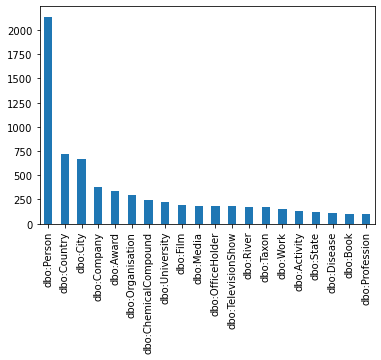

In [630]:
dbpedia_res_df['specific_type'].value_counts()[:20].plot(kind='bar')

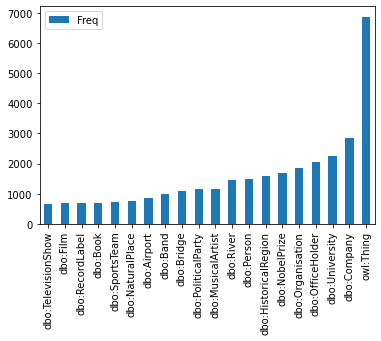

In [642]:

frq_df = pd.DataFrame.from_dict(freq_neg, orient='index', columns=['Freq'])
frq_df.head()
frq_df.sort_values(by='Freq')[-20:].plot(kind='bar')

In [444]:
VALIDATION_SPLIT = 0.2
indicies = np.arange(dbpedia_res_df.shape[0])
np.random.shuffle(indicies)
num_valid_samples = int(VALIDATION_SPLIT * dbpedia_res_df.shape[0])
num_valid_samples

dbpedia_res_df=dbpedia_res_df.iloc[indicies]
train_df= dbpedia_res_df[:-num_valid_samples]

valid_df= dbpedia_res_df[-num_valid_samples:]
print (train_df.shape, valid_df.shape)

(7646, 8) (1911, 8)


In [445]:
# take elemet-wise avegare of embedding 
def avg_embedding(tokens, emb_size=100): 
    embedding_matrix = np.zeros(emb_size)
    for i, word in enumerate(tokens):
        if wiki2vec.get_word(word):
            embedding_vector = wiki2vec.get_word_vector(word)
            embedding_matrix += embedding_vector
        if wiki2vec.get_entity(word):
            embedding_vector = wiki2vec.get_entity_vector(word)
            embedding_matrix += embedding_vector
    #print (i+1)
    return embedding_matrix/float(i+1)

# dbpedia embedding 

def avg_embedding_db(entities, emb_size=100): 
    embedding_matrix = np.zeros(emb_size)
    i=0
    for i, ent in enumerate(entities):
        #print (ent)
        if ent in word_vectors.vocab:
            embedding_vector = word_vectors[ent]
            embedding_matrix += embedding_vector
    #print (i+1)
    return embedding_matrix/float(i+1)

def avg_neg_embedding_old(tokens, emb_size=100): 
    embedding_matrix = np.zeros(emb_size)
    for i, word in enumerate(tokens):
        if wiki2vec.get_word(word):
            i = random.randint(1,4)
            r=wiki2vec.most_similar(wiki2vec.get_word(word),5)
            embedding_vector = wiki2vec.get_vector(r[i][0])
            embedding_matrix += embedding_vector
        if wiki2vec.get_entity(word):
            i = random.randint(1,4)
            r=wiki2vec.most_similar(wiki2vec.get_entity(word),5)
            embedding_vector = wiki2vec.get_vector(r[i][0])
            embedding_matrix += embedding_vector
    #print (i+1)
    return embedding_matrix/float(i+1)

def avg_neg_embedding(tokens, emb_size=100): 
    vec =avg_embedding(random.choices(tokens, k=1), emb_size=100)
    return vec

def embedding_(entity):
    #print ('entity',entity)
    #entity= entity.replace('dbo:','http://dbpedia.org/ontology/') 
    #entity = entity.replace('owl:','http://www.w3.org/2002/07/owl#')
    return word_vectors[map_to_db_entity(t)]

def embedding(entity):
  #print ('entity',entity)
    return model.wv[entity]

In [588]:
# combine embeddings for tokens of question, general and spcific answer type 
def getCombinedEmbedding(db_id, gen_type, specific_type, tokens):
    #average embedding of specific and generic types
    avg_emb = np.add(embedding(gen_type), embedding(specific_type))  / 2.0
    #avg_emb = embedding(specific_type)
    # average embedding of questions's token
    text_vec = avg_embedding(tokens.split('|'), emb_size=100)
    ques_vec = sbert_model_dict[db_id]
    #ent_vec = avg_embedding_db(id2uris[db_id], emb_size=200)
    return np.concatenate([avg_emb.reshape(1,-1),text_vec, ques_vec], axis=None)

# for multiple types
def getCombinedEmbeddings(gen_type, specific_type, tokens):
    #sub_emb = np.add(embedding(gen_type), embedding(specific_type))  / 2.0
    sub_emb = np.zeros(100)
    if type(specific_type) == list:
        for s  in specific_type:
            sub_emb = np.add(sub_emb, embedding(s))
        if len(specific_type) == 0:
            print ('zero',specific_type)
        sub_emb  = sub_emb/float(len(specific_type))
    else:
        #print (specific_type)
        sub_emb =  embedding(specific_type)
    text_vec= avg_embedding(question, emb_size=100)
    return np.concatenate([sub_emb.reshape(1,-1),text_vec], axis=None)

In [573]:
def createCombinedEmbedding(row):
    return getCombinedEmbedding(row['id'], row['general_type'],row['specific_type'], row['tokens'])

def createNegCombinedEmbedding(row, i):
    #print (row['general_type'], row['neg_spec_types'])
    return getCombinedEmbedding(row['id'], row['general_type'],row['neg_spec_types'][i], row['tokens'] )

In [562]:
row = train_df.iloc[0]
print (row)
concat_vec = createCombinedEmbedding(row)

id                                                    dbpedia_15818
question          Who is the governor of the basin countries by ...
category                                                   resource
type                                        [dbo:Person, dbo:Agent]
general_type                                              dbo:Agent
specific_type                                            dbo:Person
tokens                          countries|Lake Tahoe|governor|basin
neg_spec_types    [dbo:University, dbo:Band, dbo:PoliticalParty,...
Name: 14671, dtype: object


In [564]:
concat_vec.shape

(1224,)

In [565]:
def createFeatureMatrix(train_df, valid_df):
    train_feat= train_df.apply(createCombinedEmbedding, axis=1)
    train_neg_mat = np.empty(shape=(0, 1224))
    
    for i in range(5):   
        train_feat_neg = train_df.apply(lambda row: createNegCombinedEmbedding(row, i), axis=1)
        train_neg_mat = np.vstack([train_neg_mat, np.stack( train_feat_neg.values)])
    
    train_mat = np.vstack([np.stack( train_feat.values), train_neg_mat ])
    num_pos= int(train_mat.shape[0]/6)
    y= np.zeros(shape=(train_mat.shape[0],1))
    y[:num_pos] = 1
    
    valid_feat= valid_df.apply(createCombinedEmbedding, axis=1)
    valid_neg_mat = np.empty(shape=(0, 1224))
    for i in range(5):   
        valid_feat_neg = valid_df.apply(lambda row: createNegCombinedEmbedding(row, i), axis=1)
        valid_neg_mat = np.vstack([valid_neg_mat, np.stack( valid_feat_neg.values)])
    
    valid_mat = np.vstack([np.stack( valid_feat.values), valid_neg_mat ])
    num_pos_val = int(valid_mat.shape[0]/6)
    y_val= np.zeros(shape=(valid_mat.shape[0],1))
    y_val[:num_pos_val] = 1
    return train_mat,y, valid_mat, y_val

In [566]:
len(train_df), len(valid_df)

(7646, 1911)

In [589]:
X, y, X_val, y_val = createFeatureMatrix(train_df, valid_df)

In [590]:
from sklearn.ensemble import RandomForestClassifier

In [591]:
#train RF calssifier
rf =RandomForestClassifier(n_estimators=200,max_depth=10)
rf.fit(X, y.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [592]:
y_pred= rf.predict(X_val)

In [593]:
np.sum(y_pred.reshape(-1,1) ==y_val)/y_val.shape[0]

0.9028431885574743

In [574]:
def get_best_type(row, clf, thers=0.1):
    #print (row['question'], row['general_type'], row['type'])
    gen_type = row['general_type']
    cand_list = get_candidates(gen_type, [gen_type])
    #cand_list = train_df.specific_type.unique()
    if len(cand_list) == 0: return [gen_type]
    
    c_mat = []
    cand_list= np.array(list(cand_list))
    for c in cand_list:
        c_mat.append( getCombinedEmbedding(row['id'], row['general_type'], c, row['tokens'] ))
    probs =clf.predict_proba(c_mat)
    #print (cand_list, probs)
    best = []
    #best = np.argsort(probs[:,1])
    for i,p in enumerate(probs[:,1]):
        if p >= thers:
            best.append(cand_list[i])
    #print(best)
   
    #print (cand_list[best][-2:], probs[best][-2:])
    return [gen_type]+ best

In [595]:
valid_df.iloc[2]

id                                                    dbpedia_22682
question          Which serving railway line of the Daund Juncti...
category                                                   resource
type              [dbo:City, dbo:Settlement, dbo:PopulatedPlace,...
general_type                                              dbo:Place
specific_type                                              dbo:City
tokens                home|railway|station|Daund Junction|port|line
neg_spec_types    [dbo:Museum, dbo:Island, dbo:Asteroid, dbo:His...
Name: 2518, dtype: object

In [644]:
get_best_type(valid_df.iloc[2], rf)

['dbo:Place',
 'dbo:Building',
 'dbo:PopulatedPlace',
 'dbo:Settlement',
 'dbo:Country',
 'dbo:State',
 'dbo:City']

In [643]:
row =valid_df.iloc[241] 
print (row)
get_best_type(row, rf)

id                                                    dbpedia_17693
question          Who is the discoverer of radiocarbon dating an...
category                                                   resource
type                                        [dbo:Person, dbo:Agent]
general_type                                              dbo:Agent
specific_type                                            dbo:Person
tokens            Heidelberg|Humanities|Sciences|discoverer|dati...
neg_spec_types    [dbo:University, dbo:SoccerPlayer, dbo:Company...
Name: 13609, dtype: object


['dbo:Agent',
 'dbo:Athlete',
 'dbo:Organisation',
 'dbo:EducationalInstitution',
 'dbo:Person',
 'dbo:Company']

In [597]:
row =valid_df.iloc[19] 
print (row)
get_best_type(row, rf)


id                                                    dbpedia_15075
question          Name the occupational carcinogen causing Chlor...
category                                                   resource
type                  [dbo:ChemicalCompound, dbo:ChemicalSubstance]
general_type                                  dbo:ChemicalSubstance
specific_type                                  dbo:ChemicalCompound
tokens            molar|Name|standard|entropy|highest|Chlorometh...
neg_spec_types    [owl:Thing, owl:Thing, owl:Thing, owl:Thing, o...
Name: 13086, dtype: object


['dbo:ChemicalSubstance', 'dbo:ChemicalCompound']

In [598]:
row =valid_df.iloc[209] 
print (row)
get_best_type(row, rf)

id                                                     dbpedia_1369
question          Who is ideology of member of party of Michel P...
category                                                   resource
type                             [dbo:Ideology, dbo:TopicalConcept]
general_type                                     dbo:TopicalConcept
specific_type                                          dbo:Ideology
tokens                                        ideology|party|member
neg_spec_types    [dbo:AcademicSubject, dbo:Taxon, dbo:Taxon, ow...
Name: 656, dtype: object


['dbo:TopicalConcept',
 'dbo:Ideology',
 'dbo:AcademicSubject',
 'dbo:Taxon',
 'dbo:MusicGenre']

In [599]:
row =valid_df.iloc[210] 
print (row)
get_best_type(row, rf)

id                                                    dbpedia_15534
question          WHO IS THE MEMBER OF THE PARTY THAT PHILIP ROT...
category                                                   resource
type              [dbo:PoliticalParty, dbo:Organisation, dbo:Agent]
general_type                                              dbo:Agent
specific_type                                    dbo:PoliticalParty
tokens                                                          WHO
neg_spec_types    [dbo:Person, dbo:OfficeHolder, dbo:Scientist, ...
Name: 6896, dtype: object


['dbo:Agent',
 'dbo:Athlete',
 'dbo:Organisation',
 'dbo:EducationalInstitution',
 'dbo:Person']

In [661]:
row =valid_df.iloc[217] 
print (row)
get_best_type(row, rf)


id                                                    dbpedia_18462
question           Who is the film director of Alice's Wonderland ?
category                                                   resource
type                                        [dbo:Person, dbo:Agent]
general_type                                              dbo:Agent
specific_type                                            dbo:Person
tokens                                                director|film
neg_spec_types    [dbo:MusicalArtist, dbo:Deity, dbo:PoliticalPa...
Name: 9545, dtype: object


['dbo:Agent',
 'dbo:University',
 'dbo:Organisation',
 'dbo:EducationalInstitution',
 'dbo:Person',
 'dbo:Company']

In [660]:
row =valid_df.iloc[235] 
print (row)
get_best_type(row, rf)

id                                                    dbpedia_17655
question           What town is the birthplace of Joseph Greenberg?
category                                                   resource
type              [dbo:City, dbo:Settlement, dbo:PopulatedPlace,...
general_type                                              dbo:Place
specific_type                                              dbo:City
tokens                             town|birthplace|Joseph Greenberg
neg_spec_types    [dbo:HistoricalRegion, dbo:Church, dbo:Airport...
Name: 16369, dtype: object


['dbo:Place',
 'dbo:Building',
 'dbo:PopulatedPlace',
 'dbo:Settlement',
 'dbo:Country',
 'dbo:State',
 'dbo:Town',
 'dbo:City']

In [659]:
rf.feature_importances_[100:].sum()

0.32409629175202237

# Prediction 

In [736]:
db_valid_df =pd.read_csv('datasets/dbpedia_test_predictions.csv')

In [737]:
db_valid_df.head()

,id,question,category,type
0,dbpedia_16015,How many ingredients are in the grain} ?,literal,number
1,dbpedia_3885,Is the case fatality rate of Fournier gangrene...,boolean,boolean
2,dbpedia_12907,Does the shelf life of spinach equal 8?,boolean,boolean
3,dbpedia_7955,What sound does a pig make in the French langu...,resource,dbo:Media
4,dbpedia_2376,When was Fergie completed his record label in ...,literal,date


In [703]:
db_valid_res_df =db_valid_df[db_valid_df.category == 'resource']

In [704]:
#db_valid_res_df =db_valid_res_df[db_valid_res_df['type'] !='resource']
db_valid_res_df['general_type'] = db_valid_res_df.type.apply(multitype_to_freqtype)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [705]:
db_valid_res_df.head()

,id,question,category,type,general_type
3,dbpedia_7955,What sound does a pig make in the French langu...,resource,dbo:Media,dbo:Media
6,dbpedia_22599,Where did the war take place where one of the ...,resource,dbo:Place,dbo:Place
9,dbpedia_19677,Which mountains are contained in Inyo National...,resource,dbo:Place,dbo:Place
11,dbpedia_11163,What is the seat of Frankfurter Allgemeine Zei...,resource,dbo:Place,dbo:Place
16,dbpedia_18792,What did the people buried in Toronto die of?,resource,dbo:Agent,dbo:Agent


In [706]:
db_valid_res_df = db_valid_res_df[db_valid_res_df.question.notna()]

In [707]:
db_valid_res_df.sample(5)

,id,question,category,type,general_type
3317,dbpedia_11238,What are the participants of the cause of weat...,resource,dbo:Disease,dbo:Disease
22,dbpedia_17589,What is Janet Jackson's genre?,resource,dbo:TopicalConcept,dbo:TopicalConcept
4335,dbpedia_16922,Who is the sibling of Claudius?,resource,dbo:Agent,dbo:Agent
1499,dbpedia_266,What is the genetic association of major depre...,resource,dbo:Biomolecule,dbo:Biomolecule
2669,dbpedia_2018,What is wikibase:geoLatitude ?min that comes f...,resource,dbo:Agent,dbo:Agent


In [708]:
db_valid_res_df['tokens'] = db_valid_res_df.question.apply(lambda text: utils.tokenized_sentence(wiki2vec, text))

In [730]:
row =db_valid_res_df.iloc[235] 
print (row)
get_best_type(row, rf)

id                                                  dbpedia_20611
question        What is the name of the information appliance ...
category                                                 resource
type                                                     dbo:Name
general_type                                             dbo:Name
tokens          predecessor|whose|name|PlayStation 2|informati...
Name: 394, dtype: object


['dbo:Name', 'dbo:GivenName']

In [731]:
db_valid_res_df['pred_types']= db_valid_res_df.apply(lambda x: get_best_type(x, rf), axis=1)

In [732]:
db_valid_res_df.sample(5)

,id,question,category,type,general_type,tokens,pred_types
494,dbpedia_9173,"What is the birth place of Blackbeard, that is...",resource,dbo:Place,dbo:Place,"place|Blackbeard|,|region|birth","[dbo:Place, dbo:Building, dbo:Island, dbo:Popu..."
4000,dbpedia_12606,What are the lawn game which start with the le...,resource,dbo:Work,dbo:Work,game|letter|start|T|lawn,"[dbo:Work, dbo:Software, dbo:VideoGame, dbo:Ne..."
2855,dbpedia_6382,Where is the business headquarters location in...,resource,dbo:Agent,dbo:Agent,business|headquarters|location,"[dbo:Agent, dbo:University, dbo:Organisation, ..."
2958,dbpedia_5095,Which business is owned by the Empire State Bu...,resource,dbo:Place,dbo:Place,business|Empire State Building|owned,"[dbo:Place, dbo:Building, dbo:PopulatedPlace, ..."
938,dbpedia_15111,What is the name of the book classified in enc...,resource,dbo:Work,dbo:Work,book|encyclopedia|name|classified,"[dbo:Work, dbo:Software, dbo:VideoGame, dbo:Ne..."


In [738]:
def to_list(t):
    return [t]
db_valid_df.type = db_valid_df.type.apply(to_list)

In [739]:
for i,row in db_valid_res_df.iterrows():
    index =np.where(db_valid_df['id']==row['id'])
    #print(row['id'])
    db_valid_df.iloc[index[0][0]]['type'] =  row['pred_types']

In [741]:
db_valid_df.sample(10)

,id,question,category,type
1051,dbpedia_14345,How many film editors worked for Star Wars Epi...,literal,[number]
2309,dbpedia_23298,Give me a list of all lakes in Denmark.,resource,"[dbo:Place, dbo:Building, dbo:Island, dbo:Infr..."
592,dbpedia_20539,How many rivers are crossed by different Box G...,literal,[number]
3280,dbpedia_8008,Is the median income of Slovenia equal to 25085?,boolean,[boolean]
2788,dbpedia_16553,Purdue University is the parent organization o...,resource,"[dbo:Agent, dbo:Athlete, dbo:University, dbo:O..."
324,dbpedia_14072,Who is the director that worked for Peter Godd...,resource,"[dbo:Agent, dbo:Organisation, dbo:EducationalI..."
3546,dbpedia_10779,IS THE NUMBER OF ELEVATORS OF THE HOTEL UKRAYI...,boolean,[boolean]
505,dbpedia_11862,Does the number of out-of-school children on E...,boolean,[boolean]
2585,dbpedia_11484,How many editions of Tom Clancy's Ghost Recon ...,literal,[number]
3746,dbpedia_10310,"What city does the show ""Friends"" take place in?",resource,"[dbo:Place, dbo:Building, dbo:PopulatedPlace, ..."


In [742]:
db_valid_df[['id','category','type','question']].to_json('datasets/dbpedia_test_specific_predictions.json', orient='records')

In [686]:
db_test_pred_df =pd.read_csv('datasets/dbpedia_test_predictions.csv')

In [687]:
db_test_pred_df.head()

,id,question,category,type
0,dbpedia_16015,How many ingredients are in the grain} ?,literal,number
1,dbpedia_3885,Is the case fatality rate of Fournier gangrene...,boolean,boolean
2,dbpedia_12907,Does the shelf life of spinach equal 8?,boolean,boolean
3,dbpedia_7955,What sound does a pig make in the French langu...,resource,dbo:Media
4,dbpedia_2376,When was Fergie completed his record label in ...,literal,date


In [648]:
def to_list(t):
    return [t]
db_test_pred_df.type = db_test_pred_df.type.apply(to_list)

In [649]:
db_test_pred_df.head()

,id,question,category,type
0,dbpedia_16015,How many ingredients are in the grain} ?,literal,[number]
1,dbpedia_3885,Is the case fatality rate of Fournier gangrene...,boolean,[boolean]
2,dbpedia_12907,Does the shelf life of spinach equal 8?,boolean,[boolean]
3,dbpedia_7955,What sound does a pig make in the French langu...,resource,[dbo:Media]
4,dbpedia_2376,When was Fergie completed his record label in ...,literal,[date]


In [650]:
db_test_pred_df[['id','category','type','question']].to_json('datasets/dbpedia_test_predictions_generic_type.json', orient='records')

In [652]:
db_test_pred_df.tail()

,id,question,category,type
4376,dbpedia_8479,What is the name of a sibling duo that starts ...,resource,[dbo:Agent]
4377,dbpedia_17452,When was Nancy Reagan married to Ronald Reagan?,literal,[date]
4378,dbpedia_4571,What is the location of Edmonton,resource,[dbo:Place]
4379,dbpedia_21070,In which department does Raymond Baldwin work?,resource,[dbo:Agent]
4380,dbpedia_6276,What is Actorenregister ID for Utrecht Univers...,literal,[string]


In [653]:
len(db_test_pred_df)

4381